In [11]:
# Import live code changes in
%load_ext autoreload
%autoreload 

from pathlib import Path
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import country_converter as coco
from datetime import datetime
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Set filepaths and provide data info

In [2]:
root = Path.cwd().parent # find project root
economic = pd.read_csv(os.path.join(root, 'inputs', 'credit_risk', 'economic.csv')) # df1
SP_data = pd.read_csv(os.path.join(root, 'inputs', 'credit_risk', 'T3.csv'))
PD_data = pd.read_csv(os.path.join(root, 'inputs', 'credit_risk', 'PD_ratings.csv'), header=None)

#### Fit S&P Polynomial Models

In [3]:
gdp_losses = SP_data["GDP_per_capita"] / 100

def polyfit_raw(x, y):
    coeffs = np.polyfit(x, y, 3)
    return coeffs[::-1]   # reverse to match β0 + β1x + β2x² + β3x³

# NGGD
NGGD = np.log(SP_data["NGGD"])
b_NGGD = polyfit_raw(gdp_losses, NGGD)

# GGB (filter < 0)
sub = SP_data[SP_data["GGB"] < 0]
GGB = np.log(-sub["GGB"])
b_GGB = polyfit_raw(sub["GDP_per_capita"]/100, GGB)

# NNED (filter > 0)
sub = SP_data[SP_data["NNED"] > 0]
NNED = np.log(sub["NNED"])
b_NNED = polyfit_raw(sub["GDP_per_capita"]/100, NNED)

# CAB
CAB = np.log(-SP_data["CAB"])
b_CAB = polyfit_raw(gdp_losses, CAB)

# =========================================================
# Helper: apply polynomial
# =========================================================

def equa(A, b0, b1, b2, b3):
    return b0 + b1*A + b2*A**2 + b3*A**3

#### Prepare economic data

In [4]:
# Real GDP growth (pct change)
economic["S_RealGDPgrowth"] = economic.groupby("CountryName")["S_GDPpercapitaUS"].pct_change()

economic = economic[
    [
        "CountryName","Year","scale20","S_GDPpercapitaUS",
        "S_RealGDPgrowth","S_NetGGdebtGDP","S_GGbalanceGDP",
        "S_NarrownetextdebtCARs","S_CurrentaccountbalanceGDP"
    ]
]

cc = coco.CountryConverter()
economic["ISO2"] = cc.convert(economic["CountryName"], to="ISO3")

# Build baseline data
Baseline = economic.copy()
Baseline["ln_S_GDPpercapitaUS"] = np.log(Baseline["S_GDPpercapitaUS"])

Baseline = Baseline[Baseline["Year"] > 2014]
Baseline = Baseline.dropna()

/var/folders/7k/ml599xjx4sz6s7c8j8c00lhm0000gn/T/ipykernel_1928/482389965.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  economic["S_RealGDPgrowth"] = economic.groupby("CountryName")["S_GDPpercapitaUS"].pct_change()
Congo D.R. not found in regex
Congo D.R. not found in regex
Congo D.R. not found in regex
Congo D.R. not found in regex
Congo D.R. not found in regex
Congo D.R. not found in regex
Congo D.R. not found in regex
Congo D.R. not found in regex
Congo D.R. not found in regex
Congo D.R. not found in regex
Congo D.R. not found in regex
Congo D.R. not found in regex
Congo D.R. not found in regex
Congo D.R. not found in regex
Congo D.R. not found in regex
Congo D.R. not found in regex
Congo D.R. not found in regex
Congo D.R. not found in regex
Congo D.R. not found in regex
C

#### PD and Spreads Model

In [5]:
rating = PD_data.iloc[:, 0]
default = PD_data.iloc[:, 1]
b_PD = polyfit_raw(rating, default)

def implement_PD_equation(r):
    PD = equa(r, *b_PD)
    return np.clip(PD, 0, 100)

def calculate_spreads(C_0, notches):
    C_0 = np.asarray(C_0)
    notches = np.asarray(notches)
    return (-282.51 * notches) + (14.23 * notches * C_0)

#### Scenario Estimation

In [6]:
def estimate_country_scenario(country_, loss_):

    # extract baseline for 2020
    gdp_per_capita = Baseline[(Baseline["CountryName"] == country_) & (Baseline["Year"] == 2020)].iloc[0]

    gdp_pc_value = gdp_per_capita["S_GDPpercapitaUS"]

    estimation = pd.DataFrame({
        "CountryName": [country_],
        "loss": [loss_]
    })

    estimation["ISO2"] = cc.convert(estimation["CountryName"], to="ISO3")
    estimation["ln_S_GDPpercapitaUS"] = np.log(gdp_pc_value * (1 - loss_))
    estimation["S_RealGDPgrowth"] = -loss_

    # baseline values
    for col in ["S_NetGGdebtGDP","S_GGbalanceGDP","S_NarrownetextdebtCARs","S_CurrentaccountbalanceGDP"]:
        estimation[col] = gdp_per_capita[col]

    A = -loss_

    # apply fitted polynomial adjustments
    estimation["S_NetGGdebtGDP"] += np.exp(equa(A, *b_NGGD))
    estimation["S_GGbalanceGDP"] += -np.exp(equa(A, *b_GGB))
    estimation["S_NarrownetextdebtCARs"] += np.exp(equa(A, *b_NNED))
    estimation["S_CurrentaccountbalanceGDP"] += -np.exp(equa(A, *b_CAB))

    return estimation

#### Random Forest Risk Model

In [7]:
features = [
    "ln_S_GDPpercapitaUS",
    "S_RealGDPgrowth",
    "S_NetGGdebtGDP",
    "S_GGbalanceGDP",
    "S_NarrownetextdebtCARs",
    "S_CurrentaccountbalanceGDP"
]

X_train = Baseline[features]
y_train = Baseline["scale20"]

rf = RandomForestRegressor(
    n_estimators=2000,
    random_state=77,
    oob_score=True
)
rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",2000
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

#### Full Risk Report Function

In [8]:
def sovereign_risk_report(country_, loss_list):

    results = []

    # pull baseline once (does not depend on loss)
    original_rating = float(
        Baseline.loc[
            (Baseline["CountryName"] == country_) &
            (Baseline["Year"] == 2020),
            "scale20"
        ].iloc[0]
    )

    original_pd = implement_PD_equation(original_rating)

    for loss_ in tqdm(loss_list, desc='Running Credit Risk Analysis'):
        estimation = estimate_country_scenario(country_, loss_)

        predicted_rating = rf.predict(estimation[features])[0]
        predicted_pd = implement_PD_equation(predicted_rating)

        spread_delta = calculate_spreads(original_rating, (predicted_rating-original_rating))

        estimation = estimation.assign(
            loss=loss_,
            predicted_rating=predicted_rating,
            predicted_pd=predicted_pd,
            spread_delta=spread_delta,
            original_rating=original_rating,
            original_pd=original_pd,
        )

        results.append(estimation)
    
    return pd.concat(results, ignore_index=True)

In [9]:

# =========================================================
# PART 9 — SCENARIOS TO ESTIMATE
# =========================================================

baseline_scenario = pd.read_csv("macro_sim.csv")
# adapted_scenario = pd.read_csv("adapted_GDP.csv")

baseline_scenario['gdp'] = baseline_scenario['gdp'] * -1 / 100
# adapted_scenario['gdp_avg'] = adapted_scenario['gdp_avg'] * -1 / 100


In [10]:

# =========================================================
# PART 10 — BUILD PANDA WITH RESULTS
# =========================================================

baseline_result = sovereign_risk_report("Thailand", baseline_scenario['gdp'].values)
# adapted_result = sovereign_risk_report("Thailand", adapted_scenario['gdp_avg'].values)



Running Credit Risk Analysis: 100%|███████| 10000/10000 [10:31<00:00, 15.82it/s]


In [26]:
columns_to_keep = ["loss", "predicted_rating", "original_rating", "spread_delta", "predicted_pd", "original_pd"]
baseline_result = baseline_result[columns_to_keep]
# adapted_result = adapted_result[columns_to_keep]
baseline_result.head()

,loss,predicted_rating,original_rating,spread_delta,predicted_pd,original_pd
0,0.000031,12.4205,13.0,56.51284,3.454491,3.126746
1,-0.000000,12.4200,13.0,56.56160,3.454857,3.126746
2,0.000603,12.4160,13.0,56.95168,3.457785,3.126746
3,0.003283,12.4095,13.0,57.58556,3.462565,3.126746
4,0.000122,12.4185,13.0,56.70788,3.455954,3.126746


In [27]:
# baseline_result.to_csv('credit_ratings.csv')

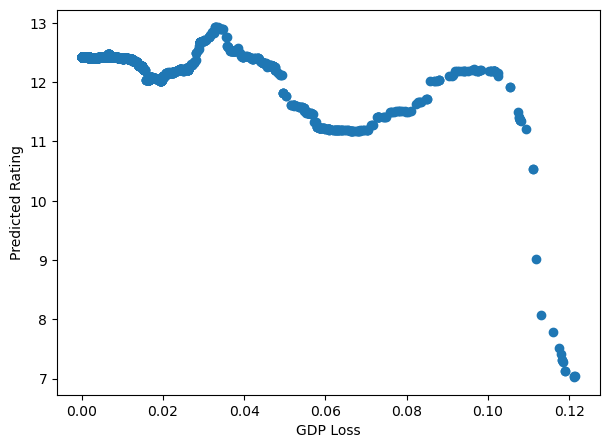

In [14]:
# Time-series
gdp_series = baseline_result['loss'].to_numpy()
rat_series = baseline_result['predicted_rating'].to_numpy()
plt.figure(figsize=(7,5))
plt.xlabel('GDP Loss')
plt.ylabel('Predicted Rating')
plt.scatter(gdp_series, rat_series)
plt.show()